# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [332]:
%matplotlib inline
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
import batman
from lightkurve.lightcurve import LightCurve
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler
import corner as triangle
err_kludge = 1.0

First we need to read in the photometry data. This notebook assumes that photometry has been performed with [AstroImageJ](https://www.astro.louisville.edu/software/astroimagej/) and a table of measurements has been saved as a .csv file. In this example, I also pull the preliminary planet and star parameters from a table that I created, but you can insert your parameters however you wish.

In [333]:
data = pandas.read_csv('Data/TESS/TIC_348538431_Data.csv')
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')

In [334]:
TIC_ID = []
names = params['TIC ID']
for i in range(len(names)):
    TIC_ID.append(int(names[i]))

In [335]:
index = int(18)
planet_name = TIC_ID[index]
observatory = 'LCO 1-m'
print(planet_name)
print(params['P (days)'][index]) #this is just to double check 

348538431
0.89949


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

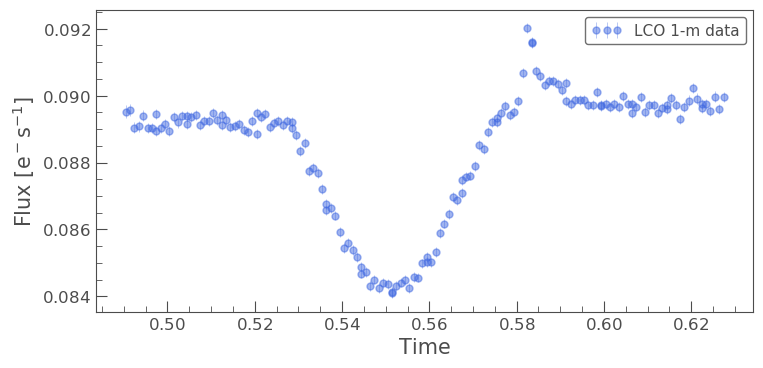

In [355]:
flux = data['rel_flux_T1']
error = data['rel_flux_err_T1']*err_kludge #the kludge inflates the error bars to give a best fit chi2=1
BJD = data['BJD-OBS']
airmass = np.array(data['AIRMASS'])

times = np.array(BJD)

offset = int(times[0])
times = times-offset # This is just a constant offset to make the x-axis more readable

lc = LightCurve(time = times, flux = flux, flux_err = error)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

Now let's turn this into a **lightkurve** object

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [356]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
epoch = params['Epoch'][index] + 2457000.0
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
i_min = np.arccos(1/planet_a)*180/np.pi - 3 #subtract 1 to get a softer lower limit
planet_duration = params['Dur (hr)'][index] #hours
C1 = np.median(lc.flux) #C1 and C2 are the airmass correction parameters
C2 = 0.0
exptime = 0.001 #60 * (1/60) * (1/60) * (1/24) #converting exposure time to days
ppm_depth = params['Depth (ppm)'][index] #ppm
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['log_g'][index] # log g
star_radius = params['R_sun'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset

for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]):
        if (mid_transit_times[i] <= lc.time[-1]):
            
            expected_t0 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0))
            print("Anticipated depth = {:.4f}".format(depth))

Anticipated mid-transit time = 0.553187
Anticipated depth = 0.9318


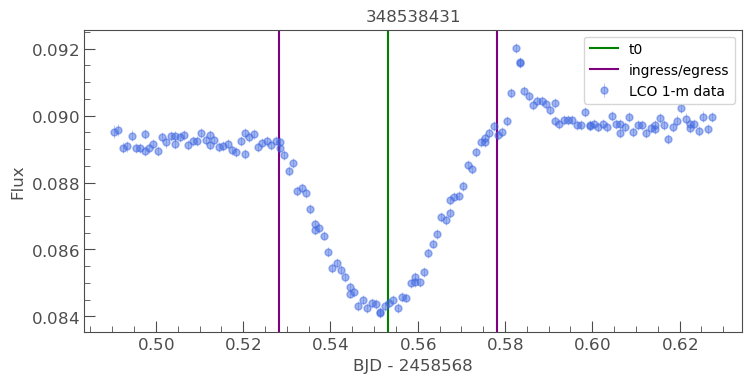

In [357]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title(planet_name)
plt.xlabel('BJD - '+str(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.legend()
plt.savefig('Figs/{}_NoFit.png'.format(planet_name))
plt.show()

Next, we will define some functions. First is a function that will calculate limb darkening coefficients using [LDTK](https://arxiv.org/abs/1508.02634):

In [358]:
def Limb_Dark(Teff=star_teff,Terr=100,log_g=star_g,g_err=0.1,met=star_met,met_err=0.01):
    
    filters = [kepler]

    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err])
    
    ps = sc.create_profiles(nsamples=500)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    LD_coeff = qc
    
    return LD_coeff

Let's calculate the LDTK coefficients right now to save ourselves computation time when we run the batman model. 

In [359]:
#LD_coeff = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
#LD = [LD_coeff[0][0],LD_coeff[0][1]]


LD = [0.6601,0.31006]

Now, we define our [batman](https://astro.uchicago.edu/~kreidberg/batman/) transit model function:

In [360]:
def BATMAN(Baseline = 1.0, # units are whatever your flux units come in
           Rp = planet_radius,
           P = planet_period,
           A = planet_a,
           inc = planet_i,
           t0 = expected_t0,
           t = None,
           exp_time = exptime):
                
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = A                         # semi-major axis (in units of stellar radii)
    params.inc = inc                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    m = batman.TransitModel(params, t, exp_time)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

Next, we will define the **lnprob** function which will be used in the MCMC calculation. This function will also create a plot of the model results.

In [361]:
def lnprob(parameters, plot = False, extra_mods = False,
           Title = planet_name, Rp_best = 0, Rp_diff = 0,
           t0_best = 0, t0_diff = 0):
        
    # Pull out some model parameters
    C1, C2, rp, t_0, a, i = parameters
    
    # First we want a model to perform the lnprob calculation with.
    model = (C1 + C2*(airmass-1))*BATMAN(Rp = rp, t0 = t_0, inc = i, A = a, t = lc.time)
    
    residual = (lc.flux-model)/lc.flux_err
    
    # This is the model that will be plotted
    model_to_plot = BATMAN(Rp = rp, t0 = t_0, inc = i, A = a, t = times)
    
    if plot:
        
        f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                                   figsize=(10,7),sharex=True)
        
        a0.set_title(Title,fontsize=20)
        a0.errorbar(lc.time,lc.flux/(C1 + C2*(airmass-1)),yerr=lc.flux_err/(C1 + C2*(airmass-1)),
                    fmt='o',alpha=0.5,color='royalblue',
                    markersize='5',label=observatory+' data')
        a0.plot(times,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
        a0.set_ylabel('Normalized Flux',fontsize=18)
        a0.minorticks_on()
        a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True)

        a1.scatter(lc.time,residual,color='royalblue',alpha=0.5)
        a1.axhline(0,color='k')
        a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
        a1.minorticks_on()
        a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
        a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=True, left=True, right=True)
        
        a0.legend(loc='lower right')
        plt.xlabel('BJD - '+str(offset),fontsize=16)
    
    # This is a Gaussian likelihood, for independent data points
    
    if (planet_radius-0.1 <= rp <= planet_radius+0.1) and (times[0] <= t_0 <= times[-1]) and (1.0 <= a <= planet_a*10) and (i_min <= i <= 90.0):
        chisq = np.sum((lc.flux - model)**2/(lc.flux_err)**2)
        lnp = (np.sum(1/np.sqrt(2*np.pi*(lc.flux_err))) - 0.5*chisq)
    
        return lnp
    
    return -np.inf

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

3037.346205625673


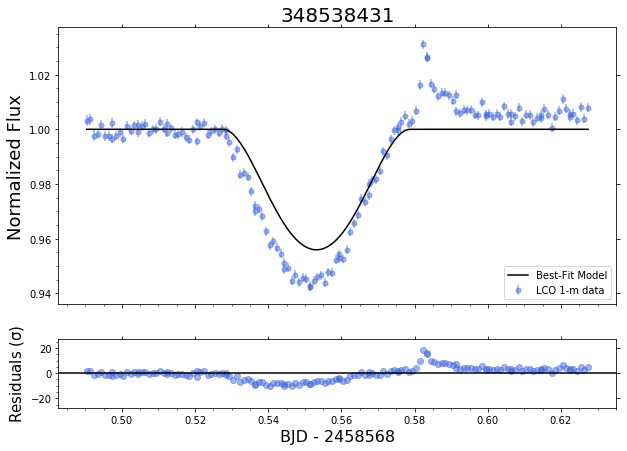

In [362]:
parameters = [C1,C2,planet_radius,expected_t0,planet_a,planet_i]
a = lnprob(parameters,plot=True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [363]:
# intialize some walkers
ndim, nwalkers, nsteps = 6, 100, 200000
burnin = int(0.25*nsteps)

# these are initial parameters
C1_init = np.random.uniform(0.08, 0.9, nwalkers)
C2_init = np.random.uniform(0.003, 0.004, nwalkers)
Rp_init = np.random.uniform(planet_radius-0.05, planet_radius+0.05, nwalkers)
t0_init = np.random.uniform(expected_t0-0.0005,expected_t0+0.0005, nwalkers)
a_init = np.random.uniform(planet_a-0.5, planet_a+0.5, nwalkers)
i_init = np.random.uniform(planet_i-1, planet_i+1, nwalkers)

p0 = np.transpose([C1_init, C2_init, Rp_init, t0_init, a_init, i_init])

In [ ]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

In [ ]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
C1, C2, Rp, t0, A, Inc = samples
np.savetxt(fname=str(planet_name)+'_samples.txt',X=samples)
C1_all, C2_all, Rp_all, t0_all, A_all, I_all = sampler.chain.T

We can inspect the distribution parameters from our MCMC by defining a function, **plot_chain**, which will show various visualizations of the results.

In [ ]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(4,2)
    
    #Walker Plots
    
    ax_Rp = plt.subplot(gs[0,0])
    ax_Rp.plot(Rp_all.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    ax_t0 = plt.subplot(gs[0,1])
    ax_t0.plot(t0_all.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_t0.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_t0.set_ylabel('t0')
    
    ax_A = plt.subplot(gs[1,0])
    ax_A.plot(A_all.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_A.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_A.set_ylabel('a/R*')
    
    ax_i = plt.subplot(gs[1,1])
    ax_i.plot(I_all.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_i.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_i.set_ylabel('Inclination')
    
    #Histograms
    
    ax_Rphist = plt.subplot(gs[2,0])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=100)
    ax_Rphist.axvline(planet_radius,zorder=100,color='purple',label='Expected Value')
    ax_Rphist.set_xlabel('Rp')
    ax_Rphist.legend()
    
    ax_t0hist = plt.subplot(gs[2,1])
    ax_t0hist.hist(t0.flatten(),color='black',bins=100)
    ax_t0hist.axvline(expected_t0,zorder=100,color='purple',label='Expected Value')
    ax_t0hist.set_xlabel('t0')
    ax_t0hist.legend()
    
    ax_Ahist = plt.subplot(gs[3,0])
    ax_Ahist.hist(A.flatten(),color='black',bins=100)
    ax_Ahist.axvline(planet_a,zorder=100,color='purple',label='Expected Value')
    ax_Ahist.set_xlabel('a/R*')
    ax_Ahist.legend()
    
    ax_ihist = plt.subplot(gs[3,1])
    ax_ihist.hist(Inc.flatten(),color='black',bins=100)
    ax_ihist.axvline(planet_i,zorder=100,color='purple',label='Expected Value')
    ax_ihist.set_xlabel('Inclination')
    ax_ihist.legend()

In [ ]:
plot_chain(burnin,nsteps)

We want to extract the best-fit parameters as well as the 1-sigma uncertainty range:

In [ ]:
sig1_C1 = np.percentile(C1, [16., 50., 84.])
sig1_C2 = np.percentile(C2, [16., 50., 84.])
sig1_Rp = np.percentile(Rp, [16., 50., 84.])
sig1_t0 = np.percentile(t0, [16., 50., 84.])
sig1_A = np.percentile(A, [16., 50., 84.])
sig1_Inc = np.percentile(Inc, [16., 50., 84.])

parameters = [sig1_C1[1],sig1_C2[1],sig1_Rp[1],sig1_t0[1],sig1_A[1],sig1_Inc[1]]

best_fit_model = (sig1_C1[1] + sig1_C2[1]*(airmass-1))*BATMAN(Rp = sig1_Rp[1], t0 = sig1_t0[1],
                                                     A = sig1_A[1], inc = sig1_Inc[1], t = lc.time)

reduced_chisq = np.sum((lc.flux - best_fit_model)**2/(lc.flux_err)**2)/(len(lc.flux)-4)     

s1 = np.sqrt(reduced_chisq)

In [ ]:
print('C1= {:.5f}'.format(sig1_C1[1]),
      '+ {:.5f}'.format(sig1_C1[2]-sig1_C1[1]),
      '- {:.5f}'.format(sig1_C1[1]-sig1_C1[0]))

print('C2= {:.5f}'.format(sig1_C2[1]),
      '+ {:.5f}'.format(sig1_C2[2]-sig1_C2[1]),
      '- {:.5f}'.format(sig1_C2[1]-sig1_C2[0]))

print('Rp/R*= {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168),'R_Earth')

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

print('Mid-Transit Time = '+str(offset)+' + '+'{:.6f}'.format(sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print("Anticipated mid-transit time = {:.6f}".format(expected_t0))

Lastly, we extract the best-fit parameters and make a plot displaying those as well as the 1-sigma models as a shaded region:

In [ ]:
def corner(samples):
        
    Range = None
    labels = ['C1','C2','Rp/R*','T0','a/R*','i (deg)']
    
    fig, axes = plt.subplots(ndim, ndim, figsize=(10,10))
    triangle.corner(samples, bins=20, labels = labels,
                   max_n_ticks=3,plot_contours=True,
                   quantiles=[0.16,0.5,0.84],fig=fig,
                   show_titles=True,verbose=True,range=Range)
    plt.show()

In [ ]:
#corner(samples)

In [ ]:
def plot_samples(parameters,Title=str(planet_name)+'.01'+' Transit Model',
                extra_mods=False,Rp_best = 0, Rp_diff = 0,
                 t0_best = 0, t0_diff = 0):
    
    C1_best, C2_best, rp_best, t_0_best, a_best, i_best = parameters
    
    model_to_plot = BATMAN(Rp = rp_best, t0 = t_0_best, inc = i_best, A = a_best, t = times)
    
    best_model = (C1_best + C2_best*(airmass-1))*BATMAN(Rp = rp_best, t0 = t_0_best, 
                                                   inc = i_best, A = a_best, t = lc.time)
    
    residual = (lc.flux-best_model)/lc.flux_err
    
    length = int(nsteps/2)
    
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title(Title,fontsize=20)
    a0.errorbar(lc.time,lc.flux/(C1_best + C2_best*(airmass-1)),
                yerr=lc.flux_err/(C1_best + C2_best*(airmass-1)),
                fmt='o',alpha=0.5,color='royalblue',markersize='5',
                label=observatory+' data')
    a0.plot(times,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Normalized Flux',fontsize=18)
    a0.minorticks_on()
    a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    for j in range(0,len(C1),length):
        i = np.random.randint(low=0,high=len(C1))
        sigma_model = BATMAN(Rp = Rp[i], t0 = t0[i], inc = Inc[i], A = A[i], t = times)
        a0.plot(times,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000)

    a1.scatter(lc.time,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.minorticks_on()
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    if extra_mods:
        y1 = BATMAN(Rp=rp, t0 = t_0+t0_diff, t = times)
        y2 = BATMAN(Rp=rp, t0 = t_0-t0_diff, t = times)
            
        a0.fill_between(times,y1,y2,label='1-$\sigma$ Models',alpha=0.5,color='red',zorder=100)
            
        y1 = BATMAN(Rp = rp+Rp_diff, t0 = t_0, t = times)
        y2 = BATMAN(Rp = rp-Rp_diff, t0 = t_0, t = times)
        a0.fill_between(times,y1,y2,alpha=0.5,color='red',zorder=100)
        
    a0.legend(loc='lower right')
    plt.xlabel('BJD - '+str(offset),fontsize=16)
    plt.savefig('Figs/'+str(planet_name)+'-01_transit.pdf')

In [ ]:
plot_samples(parameters,extra_mods=False,
             Rp_best = sig1_Rp[1],Rp_diff =(sig1_Rp[2]-sig1_Rp[1]),
             t0_best = sig1_t0[1],t0_diff =(sig1_t0[2]-sig1_t0[1]))